# Libraries & Data Loading

In [357]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from cdt.data import AcyclicGraphGenerator
from cdt.utils.graph import dagify_min_edge
import cdt
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

In [358]:
sns.set()
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [378]:
dataset_dir = "datasets"

breast_cancer_df = pd.read_csv(f"{dataset_dir}/breast_cancer.csv")
thyroid_df = pd.read_csv(f"{dataset_dir}/thyroid.csv")
cardio_df = pd.read_csv(f"{dataset_dir}/cardio.csv", delimiter=";", index_col='id')

## Breast cancer dataset preprocessing

In [379]:
breast_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [380]:
# # Convert column "diagnosis" from categorical to binary
# breast_cancer_df.loc[breast_cancer_df['diagnosis'] == "M", 'diagnosis'] = 1
# breast_cancer_df.loc[breast_cancer_df['diagnosis'] == "B", 'diagnosis'] = 0

# # Drop colum "Unnamed: 32" (contains only nan values)
# breast_cancer_df.drop(columns=["Unnamed: 32", 'id'], inplace=True)
# #target_bc = breast_cancer_df.pop('diagnosis').to_numpy().astype(int)

In [381]:
# Convert column "diagnosis" from categorical to binary
breast_cancer_df.loc[breast_cancer_df['diagnosis'] == "M", 'diagnosis'] = 1.0
breast_cancer_df.loc[breast_cancer_df['diagnosis'] == "B", 'diagnosis'] = 0.0

# Drop colum "Unnamed: 32" (contains only nan values)
breast_cancer_df.drop(columns=["Unnamed: 32", 'id'], inplace=True)

Text(0.5, 1.0, 'Diagnosis Distribution in Breast Cancer data')

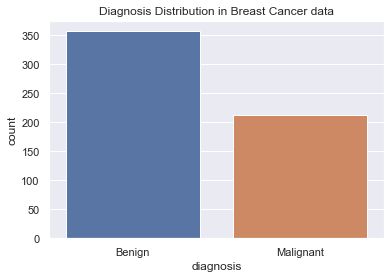

In [382]:
sns.countplot(breast_cancer_df['diagnosis'])
plt.xticks(ticks=[0,1], labels=['Benign', 'Malignant'])
plt.title('Diagnosis Distribution in Breast Cancer data')

In [383]:
breast_cancer_df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.00,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,0.24,0.08,1.09,0.91,8.59,153.40,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12
1,1.00,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09
2,1.00,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,94.03,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,1.00,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,0.26,0.10,0.50,1.16,3.44,27.23,0.01,0.07,0.06,0.02,0.06,0.01,14.91,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17
4,1.00,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,0.06,0.76,0.78,5.44,94.44,0.01,0.02,0.06,0.02,0.02,0.01,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1.00,21.56,22.39,142.00,1479.00,0.11,0.12,0.24,0.14,0.17,0.06,1.18,1.26,7.67,158.70,0.01,0.03,0.05,0.02,0.01,0.00,25.45,26.40,166.10,2027.00,0.14,0.21,0.41,0.22,0.21,0.07
565,1.00,20.13,28.25,131.20,1261.00,0.10,0.10,0.14,0.10,0.18,0.06,0.77,2.46,5.20,99.04,0.01,0.02,0.04,0.02,0.02,0.00,23.69,38.25,155.00,1731.00,0.12,0.19,0.32,0.16,0.26,0.07
566,1.00,16.60,28.08,108.30,858.10,0.08,0.10,0.09,0.05,0.16,0.06,0.46,1.07,3.42,48.55,0.01,0.04,0.05,0.02,0.01,0.00,18.98,34.12,126.70,1124.00,0.11,0.31,0.34,0.14,0.22,0.08
567,1.00,20.60,29.33,140.10,1265.00,0.12,0.28,0.35,0.15,0.24,0.07,0.73,1.59,5.77,86.22,0.01,0.06,0.07,0.02,0.02,0.01,25.74,39.42,184.60,1821.00,0.17,0.87,0.94,0.27,0.41,0.12


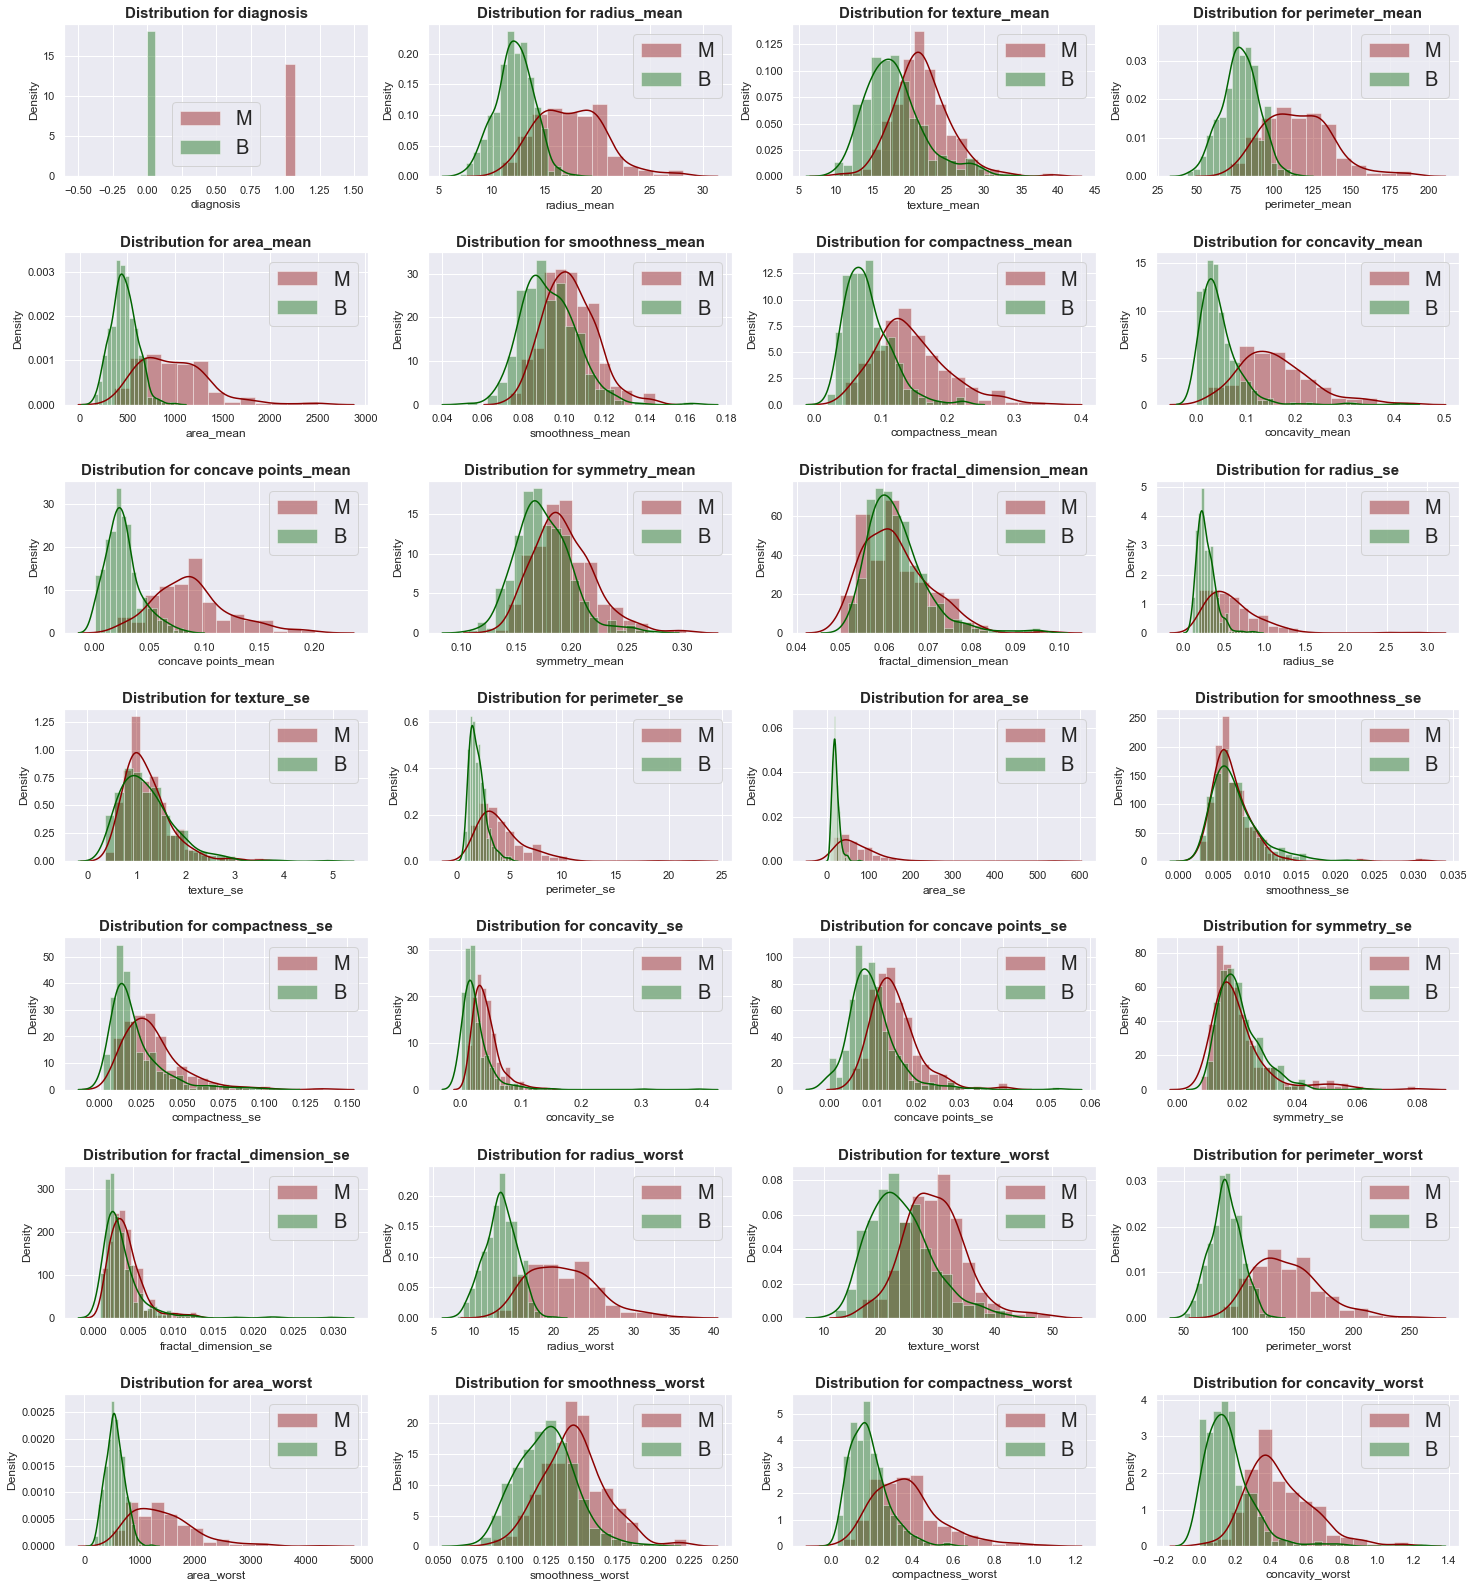

In [384]:
x = breast_cancer_df
num_feat = x.shape[1]-3
fig = plt.figure(figsize=(25, num_feat))
fig.subplots_adjust(hspace=.5)
axs = [fig.add_subplot(num_feat / 4, 4, i + 1) for i in range(num_feat)]

for i, column in enumerate(x.columns[:-3]):
    sns.distplot(x[x.diagnosis == 1][column], ax=axs[i], color='darkred', label="M")
    sns.distplot(x[x.diagnosis == 0][column], ax=axs[i], color='darkgreen', label="B")
    axs[i].set_title('Distribution for {}'.format( column), fontweight='bold', fontsize=15)
    axs[i].legend(fontsize=20)
plt.show()

In [385]:
corr_df = pd.DataFrame(scaler.fit_transform(breast_cancer_df.to_numpy()), columns=breast_cancer_df.columns)
corr_df = pd.DataFrame(corr_df.iloc[:,1:].corrwith(corr_df['diagnosis'])).sort_values(by=0, ascending=False)
corr = corr_df.T
corr

,concave points_worst,perimeter_worst,concave points_mean,radius_worst,perimeter_mean,area_worst,radius_mean,area_mean,concavity_mean,concavity_worst,compactness_mean,compactness_worst,radius_se,perimeter_se,area_se,texture_worst,smoothness_worst,symmetry_worst,texture_mean,concave points_se,smoothness_mean,symmetry_mean,fractal_dimension_worst,compactness_se,concavity_se,fractal_dimension_se,symmetry_se,texture_se,fractal_dimension_mean,smoothness_se
0,0.79,0.78,0.78,0.78,0.74,0.73,0.73,0.71,0.70,0.66,0.60,0.59,0.57,0.56,0.55,0.46,0.42,0.42,0.42,0.41,0.36,0.33,0.32,0.29,0.25,0.08,-0.01,-0.01,-0.01,-0.07


In [386]:
scaler = StandardScaler()
breast_cancer_df1 = breast_cancer_df.drop('diagnosis', axis=1)
breast_cancer_df1 = pd.DataFrame(scaler.fit_transform(breast_cancer_df1.to_numpy()), columns=breast_cancer_df1.columns)
breast_cancer_df1 = breast_cancer_df1[list(corr_df.T.columns)].iloc[:, :10]
breast_cancer_df1.insert(loc=0, column='diagnosis', value=breast_cancer_df['diagnosis'])
breast_cancer_df = breast_cancer_df1

In [387]:
breast_cancer_df

,diagnosis,concave points_worst,perimeter_worst,concave points_mean,radius_worst,perimeter_mean,area_worst,radius_mean,area_mean,concavity_mean,concavity_worst
0,1.00,2.30,2.30,2.53,1.89,1.27,2.00,1.10,0.98,2.65,2.11
1,1.00,1.09,1.54,0.55,1.81,1.69,1.89,1.83,1.91,-0.02,-0.15
2,1.00,1.96,1.35,2.04,1.51,1.57,1.46,1.58,1.56,1.36,0.85
3,1.00,2.18,-0.25,1.45,-0.28,-0.59,-0.55,-0.77,-0.76,1.92,1.99
4,1.00,0.73,1.34,1.43,1.30,1.78,1.22,1.75,1.83,1.37,0.61
...,...,...,...,...,...,...,...,...,...,...,...
564,1.00,1.63,1.75,2.32,1.90,2.06,2.02,2.11,2.34,1.95,0.66
565,1.00,0.73,1.42,1.26,1.54,1.62,1.49,1.70,1.72,0.69,0.24
566,1.00,0.41,0.58,0.11,0.56,0.67,0.43,0.70,0.58,0.05,0.33
567,1.00,2.29,2.30,2.66,1.96,1.98,1.65,1.84,1.74,3.30,3.20


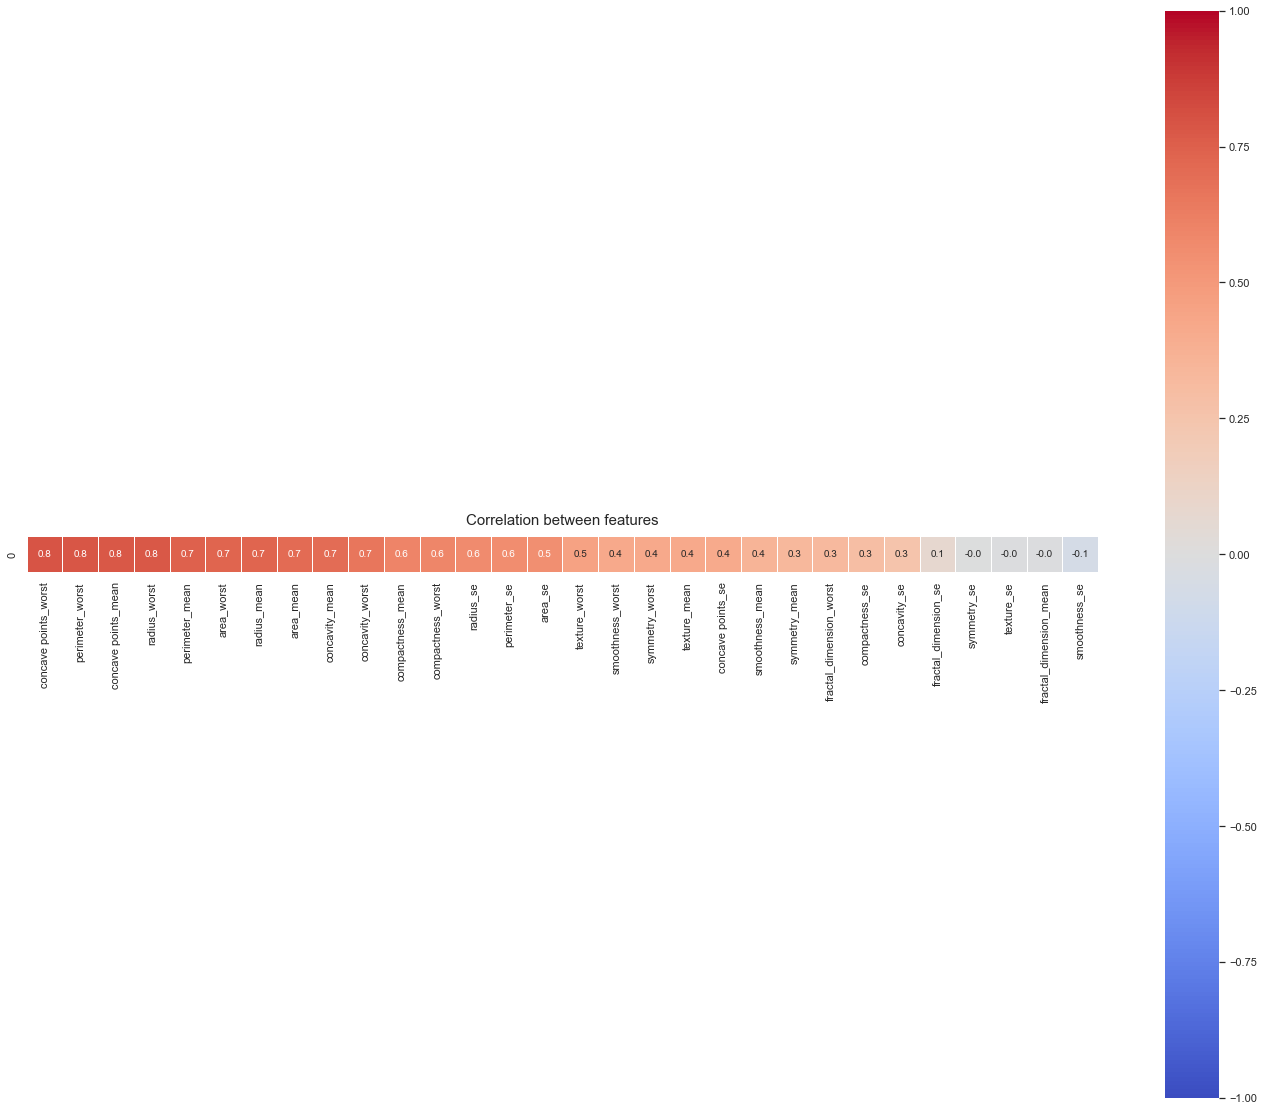

In [388]:
# plt.figure(figsize=(10,10))
# sns.heatmap(breast_cancer_df.corr(), linewidth=.5, square=True, cmap='inferno')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(24, 20))
heatmap = sns.heatmap(corr, square=True, linewidths=.5,
                      vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt='.1f')
heatmap.set_title('Correlation between features',
                  fontdict={'fontsize': 15}, pad=12)
fig.show()


## Thyroid dataset preprocessing

In [389]:
thyroid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on thyroxine               3772 non-null   object
 3   query on thyroxine         3772 non-null   object
 4   on antithyroid medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid surgery            3772 non-null   object
 8   I131 treatment             3772 non-null   object
 9   query hypothyroid          3772 non-null   object
 10  query hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [390]:
# Binarize textual data
thyroid_df.replace({'F': 0., 'f': 0., 'M': 1., 't': 1., "P": 1., "N": 0.}, inplace=True)

# Categorical encoding for "referreal source" column
thyroid_df.replace({'SVHC': 0, 'SVI': 1, 'STMW': 2, 'SVHD': 3, 'other': -1}, inplace=True)

# "?" values have to removed. They cannot be mapped to np.nan because the algorithm won't work. I decided to map those values to 0, but we should discuss this choice
thyroid_df.replace({'?': 0.}, inplace=True)

In [391]:
# There are no measurements for TBG, can be dropped
thyroid_df.drop(columns=["TBG", "TBG measured"], inplace=True)
#target_t = thyroid_df.pop('binaryClass').to_numpy().astype(int)

Text(0.5, 1.0, 'Diagnosis Distribution in Thyroid data')

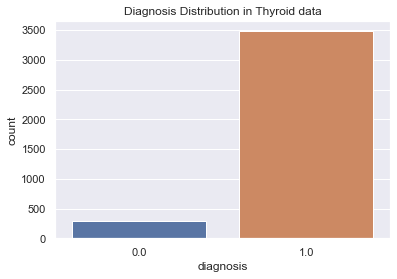

In [392]:
sns.countplot(thyroid_df['binaryClass'])
plt.xlabel('diagnosis')
plt.title('Diagnosis Distribution in Thyroid data')

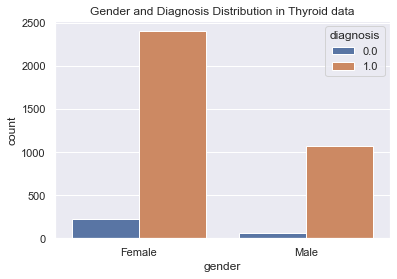

In [393]:
sns.countplot(thyroid_df['sex'], hue=thyroid_df['binaryClass'])
plt.xlabel('gender')
plt.xticks(ticks=[0,1], labels=['Female', 'Male'])
plt.title('Gender and Diagnosis Distribution in Thyroid data')
plt.legend(title='diagnosis')

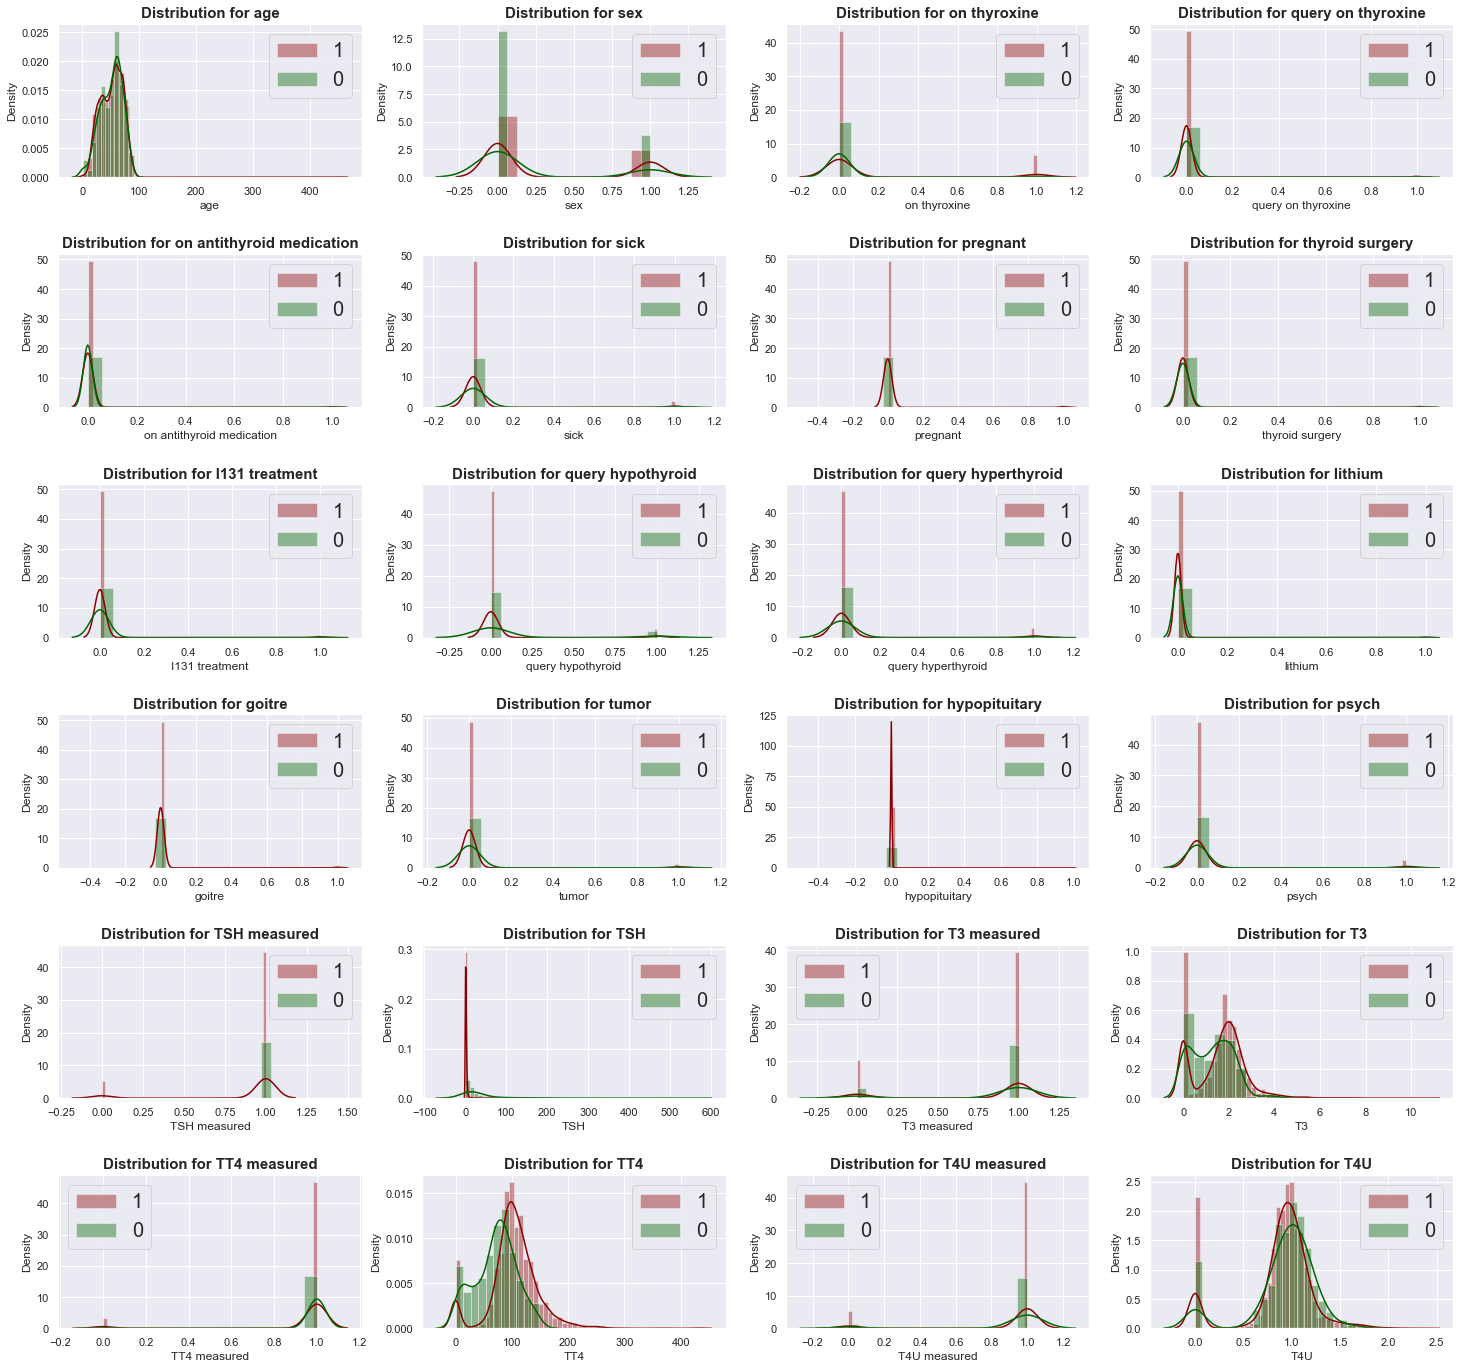

In [394]:
x = thyroid_df
num_feat = x.shape[1]-4
fig = plt.figure(figsize=(25, num_feat))
fig.subplots_adjust(hspace=.5)
axs = [fig.add_subplot(num_feat / 4, 4, i + 1) for i in range(num_feat)]

for i, column in enumerate(x.columns[:-4]):
    sns.distplot(x[x.binaryClass == 1][column], ax=axs[i], color='darkred', label="1")
    sns.distplot(x[x.binaryClass == 0][column], ax=axs[i], color='darkgreen', label="0")
    axs[i].set_title('Distribution for {}'.format( column), fontweight='bold', fontsize=15)
    axs[i].legend(fontsize=20)
plt.show()

In [395]:
scaler = StandardScaler()
binaryClass = thyroid_df['binaryClass']
thyroid_df = thyroid_df.iloc[:, :-1]
thyroid_df = pd.DataFrame(scaler.fit_transform(thyroid_df.to_numpy()), columns=thyroid_df.columns)
thyroid_df.insert(loc=0, column='binaryClass', value=binaryClass)

thyroid_df = thyroid_df.iloc[:, :18]

## Cardiovascular disease dataset preprocessing

In [396]:
cardio_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


Text(0.5, 1.0, 'Diagnosis Distribution in Cardiovascular data')

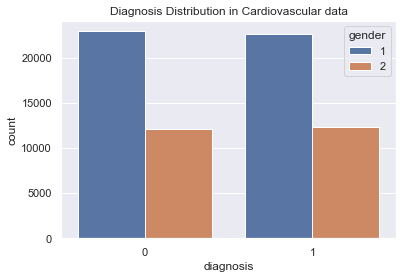

In [397]:
sns.countplot(cardio_df['cardio'], hue=cardio_df['gender'])
plt.xlabel('diagnosis')
plt.title('Diagnosis Distribution in Cardiovascular data')

Text(0.5, 1.0, 'Gender Distribution in CardioVascular data')

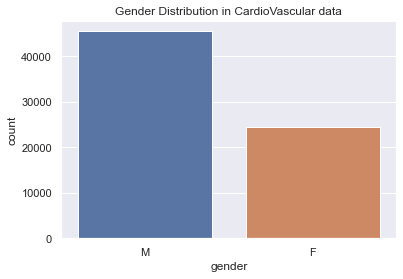

In [398]:
sns.countplot(cardio_df['gender'])
plt.xticks(ticks=[0,1], labels=['M', 'F'])
plt.title('Gender Distribution in CardioVascular data')

In [399]:
cardio_df['age'] = round(cardio_df['age']/365.0, 0)

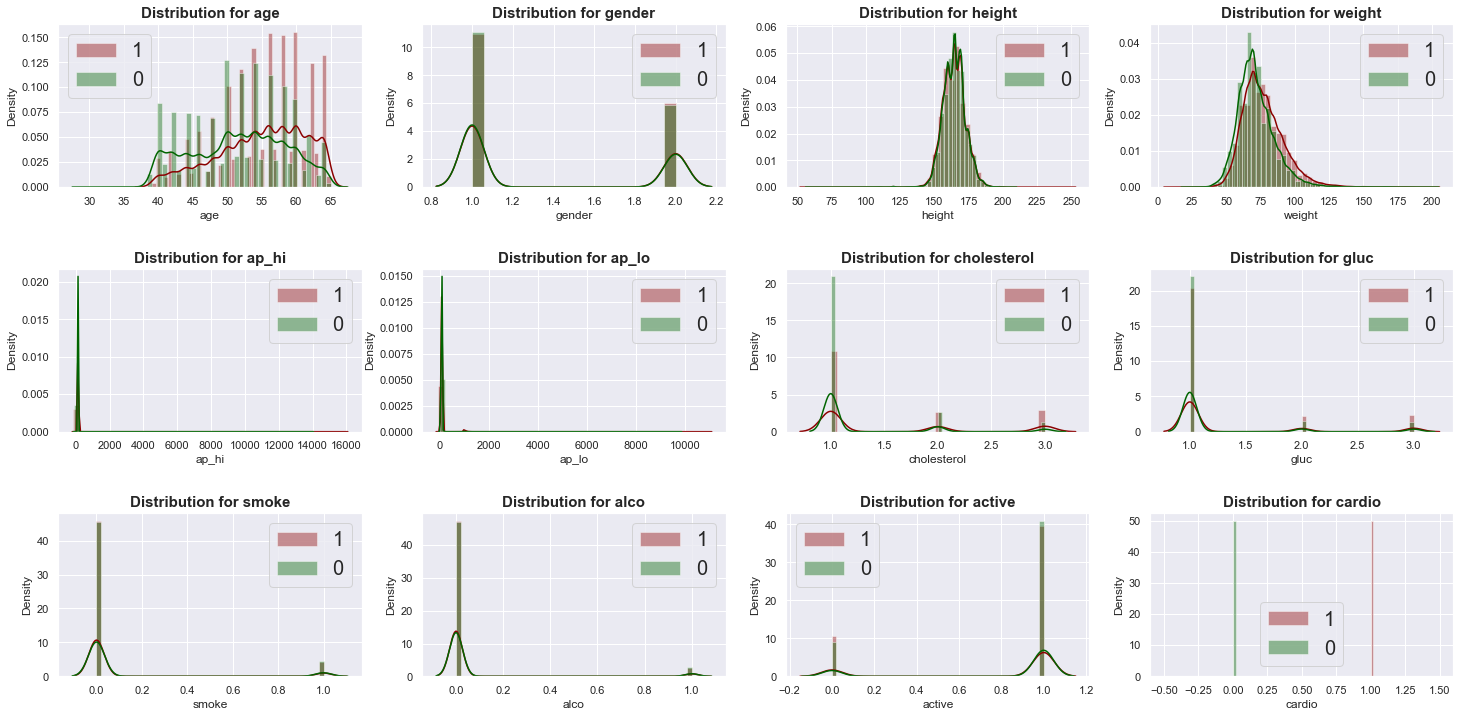

In [400]:
x = cardio_df
num_feat = x.shape[1]
fig = plt.figure(figsize=(25, num_feat))
fig.subplots_adjust(hspace=.5)
axs = [fig.add_subplot(num_feat / 4, 4, i + 1) for i in range(num_feat)]

for i, column in enumerate(x.columns[:]):
    sns.distplot(x[x.cardio == 1][column], ax=axs[i], color='darkred', label="1")
    sns.distplot(x[x.cardio == 0][column], ax=axs[i], color='darkgreen', label="0")
    axs[i].set_title('Distribution for {}'.format( column), fontweight='bold', fontsize=15)
    axs[i].legend(fontsize=20)
plt.show()

In [401]:
scaler = StandardScaler()
#diagnosis = cardio_df['cardio']
#cardio_df = cardio_df.drop('cardio', axis=1)
cardio_df = pd.DataFrame(scaler.fit_transform(cardio_df.to_numpy()), columns=cardio_df.columns)
#cardio_df['diagnosis'] = diagnosis

In [402]:
cardio_df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

# Independence graphs

##### Breast Cancer Data

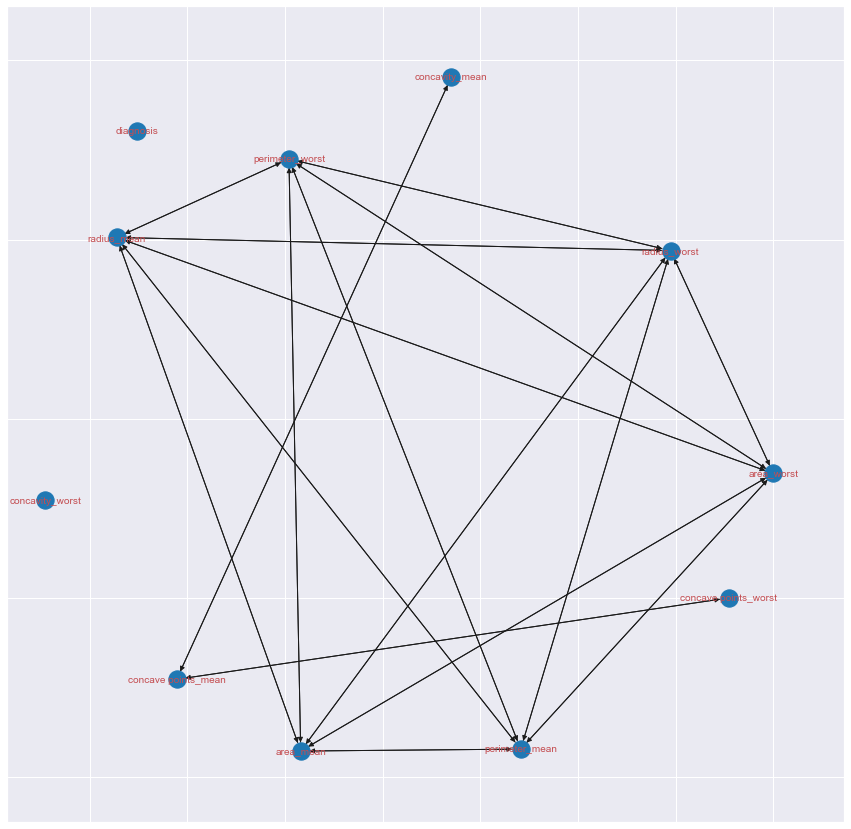

In [422]:
# intialize graph lasso
glasso = cdt.independence.graph.Glasso()

# apply graph lasso to dataset
skeleton_bc = glasso.predict(breast_cancer_df, 0.9)
skeleton_bc.remove_edges_from(nx.selfloop_edges(skeleton_bc))
# skeleton_bc = dagify_min_edge(skeleton_bc)
# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(skeleton_bc, font_size=10, font_color='r')

##### Thyroid Data

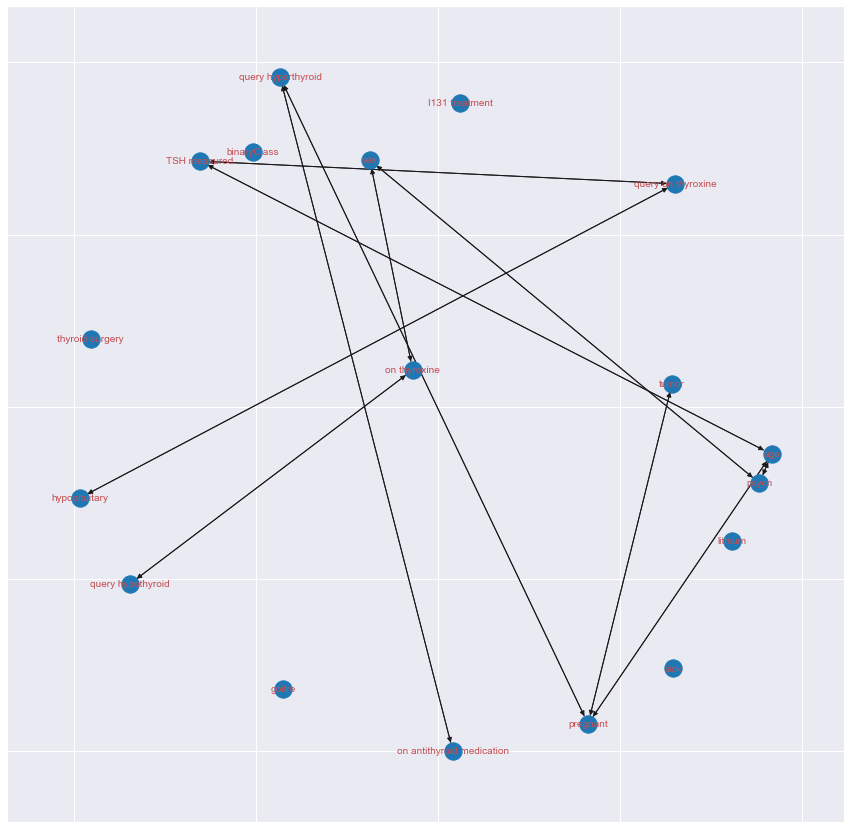

In [423]:
# intialize graph lasso
glasso = cdt.independence.graph.Glasso()

# apply graph lasso to dataset
skeleton_t = glasso.predict(thyroid_df, 0.08)
skeleton_t.remove_edges_from(nx.selfloop_edges(skeleton_t))

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(skeleton_t, font_size=10, font_color='r')

##### Cardio Data

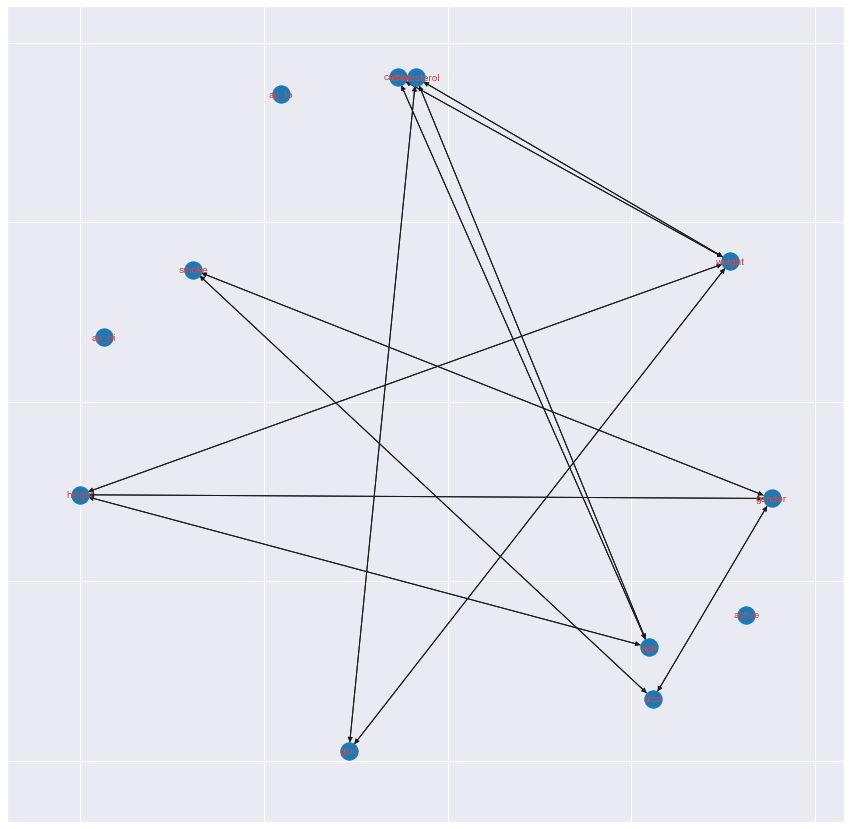

In [424]:
# intialize graph lasso
glasso = cdt.independence.graph.Glasso()

# apply graph lasso to dataset
skeleton_c = glasso.predict(cardio_df, 0.08)
skeleton_c.remove_edges_from(nx.selfloop_edges(skeleton_c))

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(skeleton_c, font_size=10, font_color='r')

# PC

## Constrained

##### Breast Cancer Data

,Cause,Effect,Score
0,area_mean,perimeter_worst,1
9,radius_mean,area_worst,1
15,radius_worst,perimeter_mean,1
14,radius_worst,area_worst,1
13,radius_worst,area_mean,1
12,radius_mean,radius_worst,1
11,radius_mean,perimeter_worst,1
10,radius_mean,perimeter_mean,1
8,radius_mean,area_mean,1
1,area_worst,area_mean,1


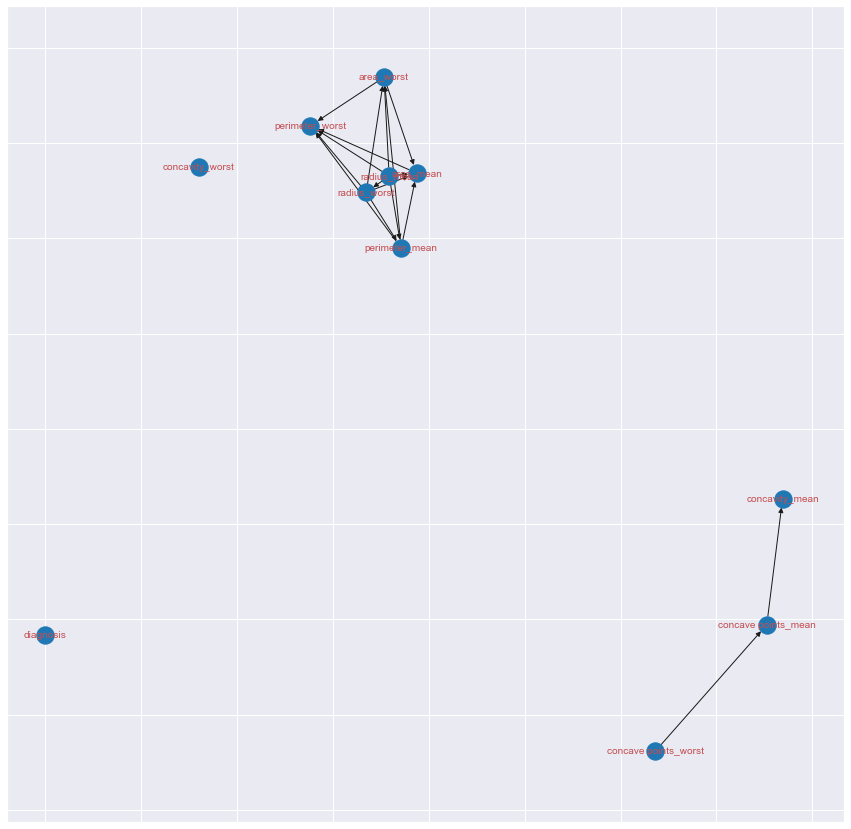

In [472]:
model_pc = cdt.causality.graph.PC()
graph_pc_c = model_pc.predict(breast_cancer_df, skeleton_bc)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_pc_c), font_size=10, font_color='r')
pd.DataFrame(list(graph_pc_c.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

##### Thyroid Data

,Cause,Effect,Score
0,TSH measured,age,1
1,TSH measured,query on thyroxine,1
2,age,psych,1
3,hypopituitary,query on thyroxine,1
4,on antithyroid medication,query hyperthyroid,1
5,on thyroxine,sex,1
6,pregnant,age,1
7,pregnant,query hyperthyroid,1
8,pregnant,tumor,1
9,query hypothyroid,on thyroxine,1


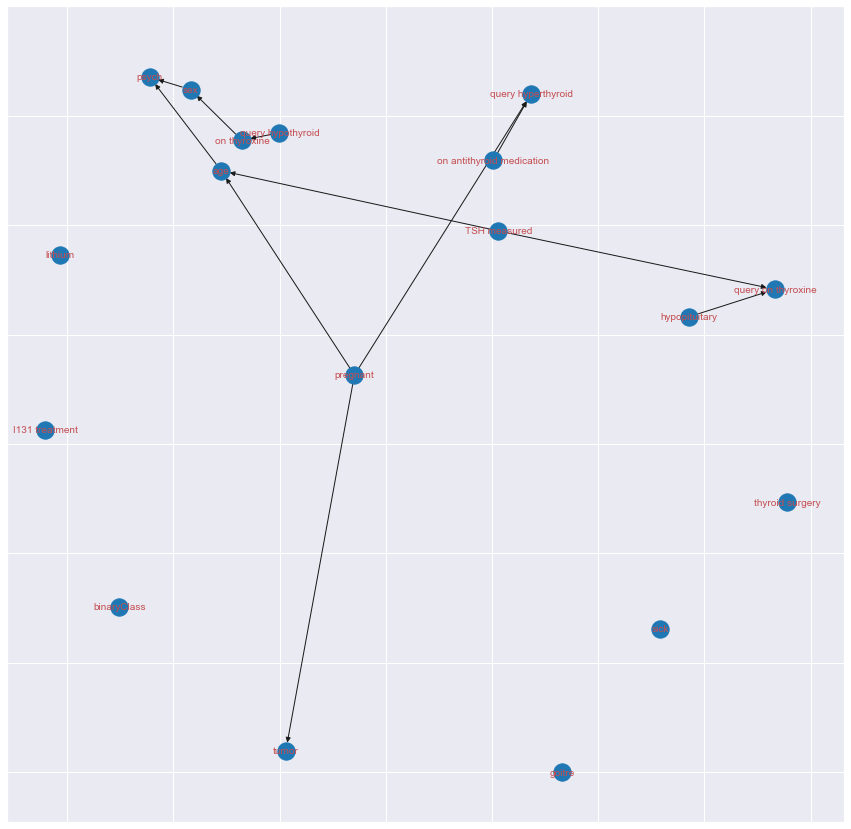

In [473]:
model_pc = cdt.causality.graph.PC()
graph_pc_c = model_pc.predict(thyroid_df, skeleton_t)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_pc_c), font_size=10, font_color='r')
pd.DataFrame(list(graph_pc_c.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")
#nx.draw_shell(dagify_min_edge(graph_pc_c), font_size=10,node_size=1000 ,with_labels=True)

###### Cardio Data

,Cause,Effect,Score
0,age,cardio,1
1,age,height,1
2,alco,gender,1
3,cardio,weight,1
4,cholesterol,cardio,1
5,cholesterol,gluc,1
6,cholesterol,weight,1
7,gender,height,1
8,gluc,weight,1
9,height,weight,1


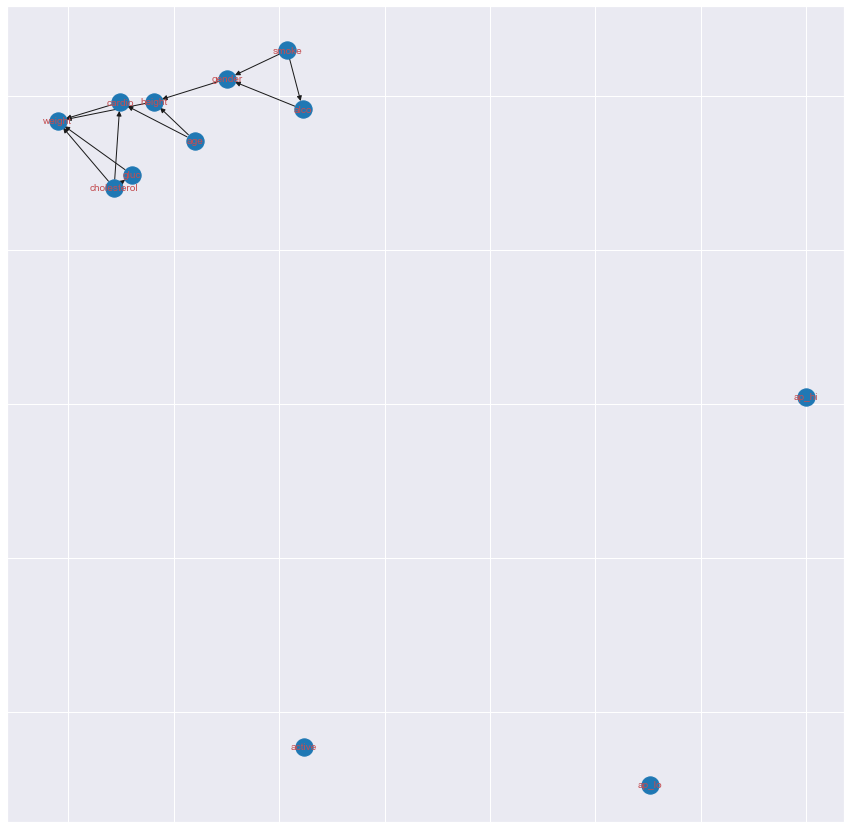

In [474]:
model_pc = cdt.causality.graph.PC()
graph_pc_c = model_pc.predict(cardio_df, skeleton_c)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_pc_c), font_size=10, font_color='r')
pd.DataFrame(list(graph_pc_c.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

## Unconstrained

##### Breast Cancer Data

,Cause,Effect,Score
0,diagnosis,concave points_worst,1
1,concave points_worst,concavity_mean,1
2,perimeter_worst,perimeter_mean,1
3,concave points_mean,concave points_worst,1
4,concave points_mean,perimeter_mean,1
5,concave points_mean,concavity_mean,1
6,radius_worst,perimeter_worst,1
7,area_worst,radius_worst,1
8,radius_mean,perimeter_mean,1
9,radius_mean,area_mean,1


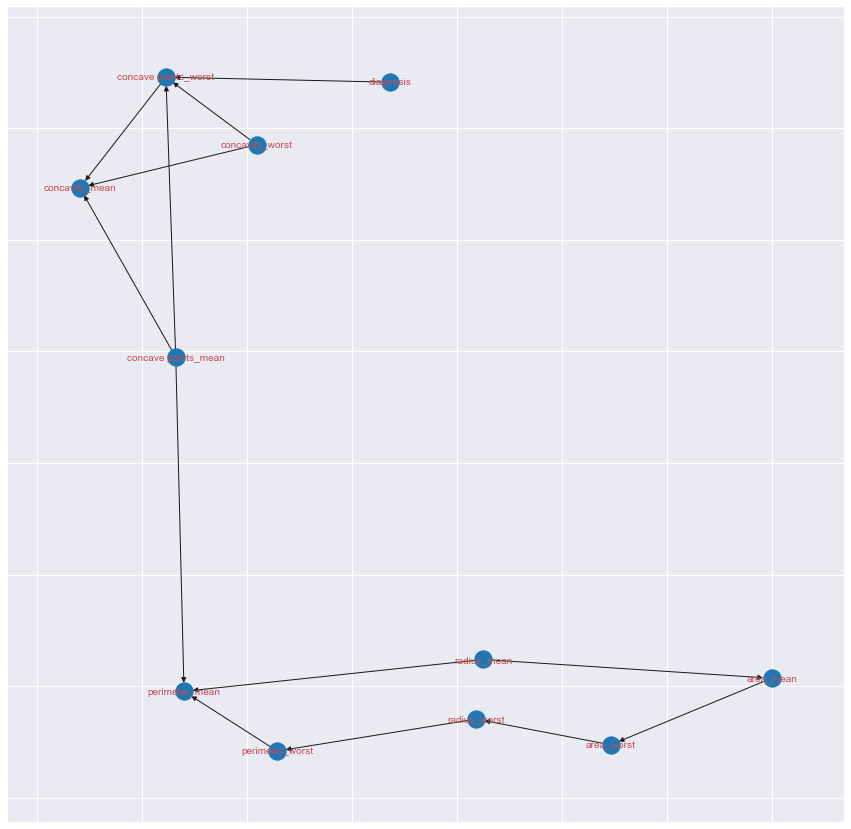

In [475]:
model_pc = cdt.causality.graph.PC()
graph_pc_u = model_pc.predict(breast_cancer_df)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_pc_u), font_size=10, font_color='r')
pd.DataFrame(list(graph_pc_u.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

##### Thyroid Data

,Cause,Effect,Score
0,binaryClass,on thyroxine,1
15,pregnant,age,1
27,TSH measured,query hyperthyroid,1
26,hypopituitary,query on thyroxine,1
25,tumor,sex,1
24,tumor,TSH measured,1
23,goitre,TSH measured,1
22,goitre,age,1
21,query hyperthyroid,psych,1
20,query hyperthyroid,sex,1


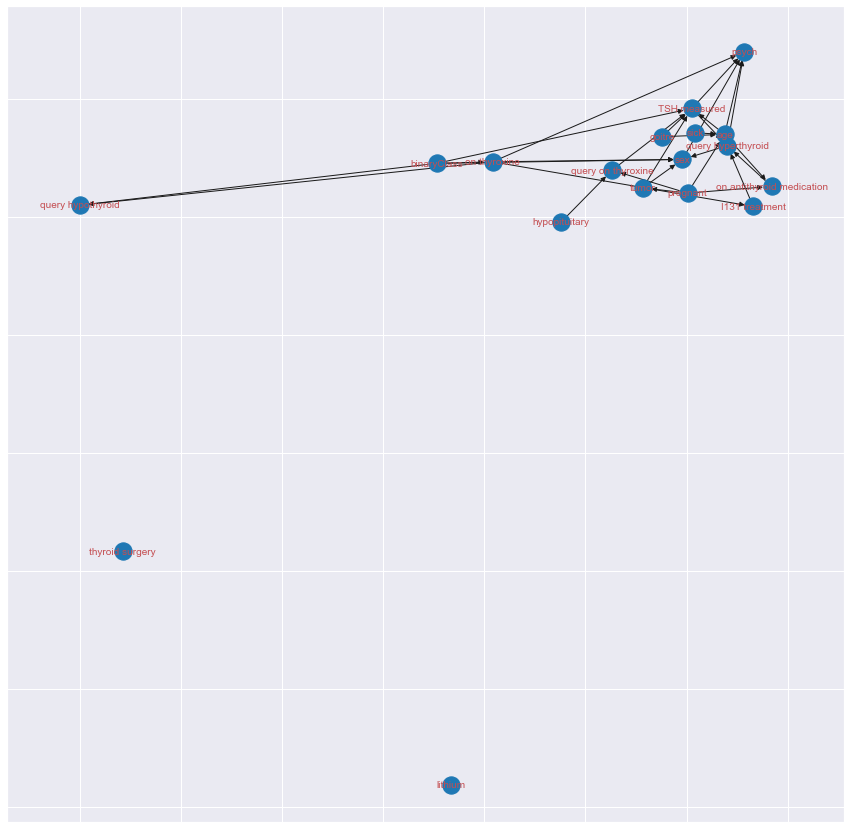

In [476]:
model_pc = cdt.causality.graph.PC()
graph_pc_u = model_pc.predict(thyroid_df)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_pc_u), font_size=10, font_color='r')
pd.DataFrame(list(graph_pc_u.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

##### Cardio Data

,Cause,Effect,Score
0,age,height,1
15,smoke,age,1
27,cardio,ap_lo,1
26,cardio,ap_hi,1
25,cardio,weight,1
24,cardio,age,1
23,active,cardio,1
22,active,alco,1
21,active,smoke,1
20,alco,weight,1


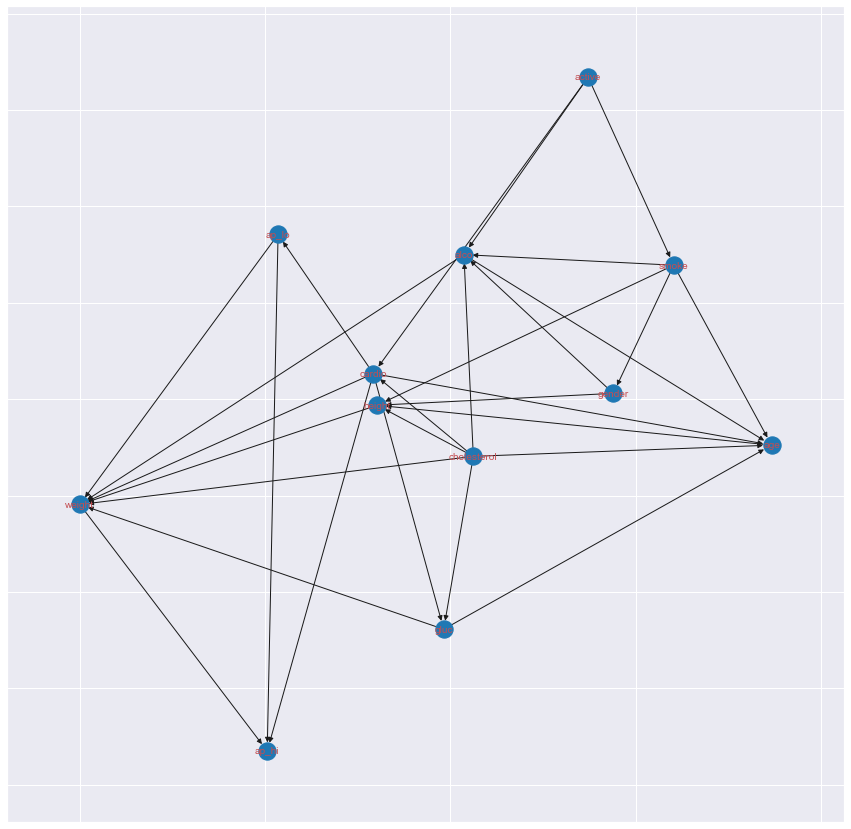

In [477]:
model_pc = cdt.causality.graph.PC()
graph_pc_u = model_pc.predict(cardio_df)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_pc_u), font_size=10, font_color='r')
pd.DataFrame(list(graph_pc_u.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

# GES

## Constrained

##### Breast Cancer Data

,Cause,Effect,Score
0,area_worst,area_mean,1
1,area_worst,radius_worst,1
2,concave points_mean,concavity_mean,1
3,concave points_worst,concave points_mean,1
4,perimeter_mean,area_mean,1
5,perimeter_mean,area_worst,1
6,perimeter_mean,perimeter_worst,1
7,perimeter_worst,area_worst,1
8,perimeter_worst,radius_worst,1
9,radius_mean,area_worst,1


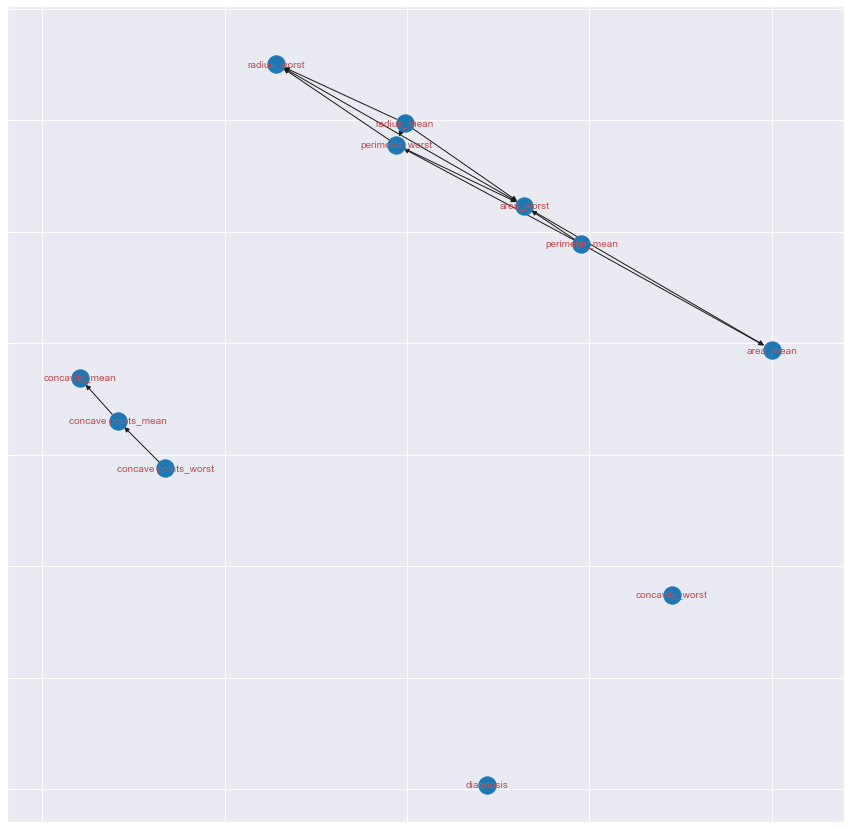

In [478]:
# GES algorithm
model_ges = cdt.causality.graph.GES()
graph_ges_c = model_ges.predict(breast_cancer_df, skeleton_bc)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_ges_c), font_size=10, font_color='r')
pd.DataFrame(list(graph_ges_c.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

##### Thyroid Data

,Cause,Effect,Score
0,TSH measured,query on thyroxine,1
1,on antithyroid medication,query hyperthyroid,1
2,pregnant,query hyperthyroid,1


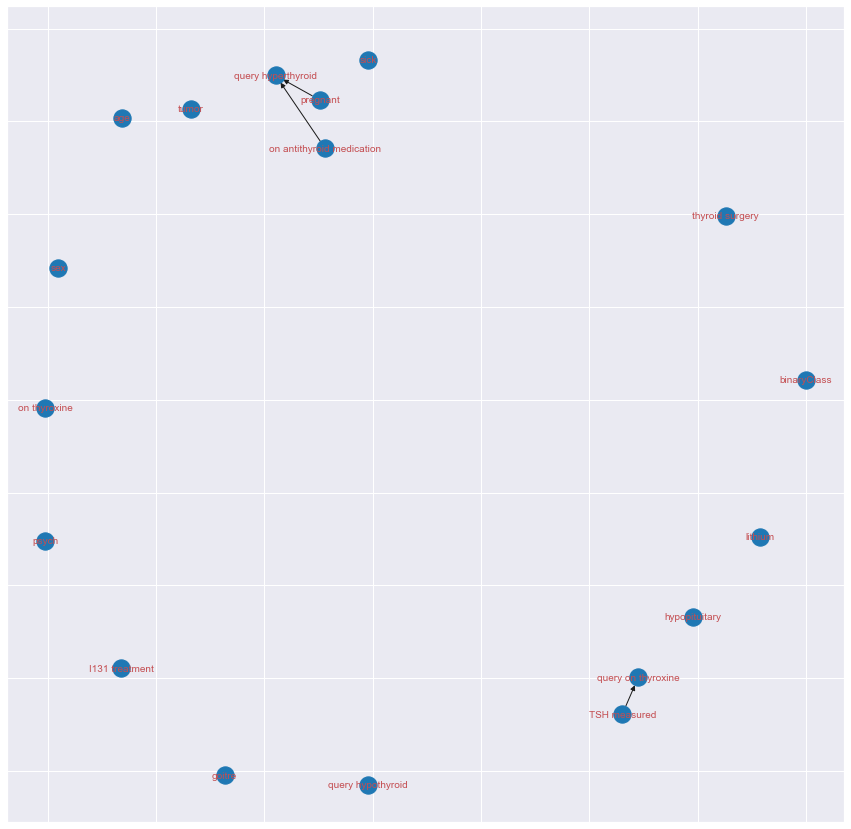

In [480]:
# GES algorithm
model_ges = cdt.causality.graph.GES()
graph_ges_c = model_ges.predict(thyroid_df, skeleton_t)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_ges_c), font_size=10, font_color='r')
pd.DataFrame(list(graph_ges_c.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

##### Cardio Data

,Cause,Effect,Score
0,age,cardio,1
1,alco,gender,1
2,cholesterol,age,1
3,cholesterol,weight,1
4,gluc,weight,1
5,height,age,1
6,height,gender,1
7,weight,cardio,1


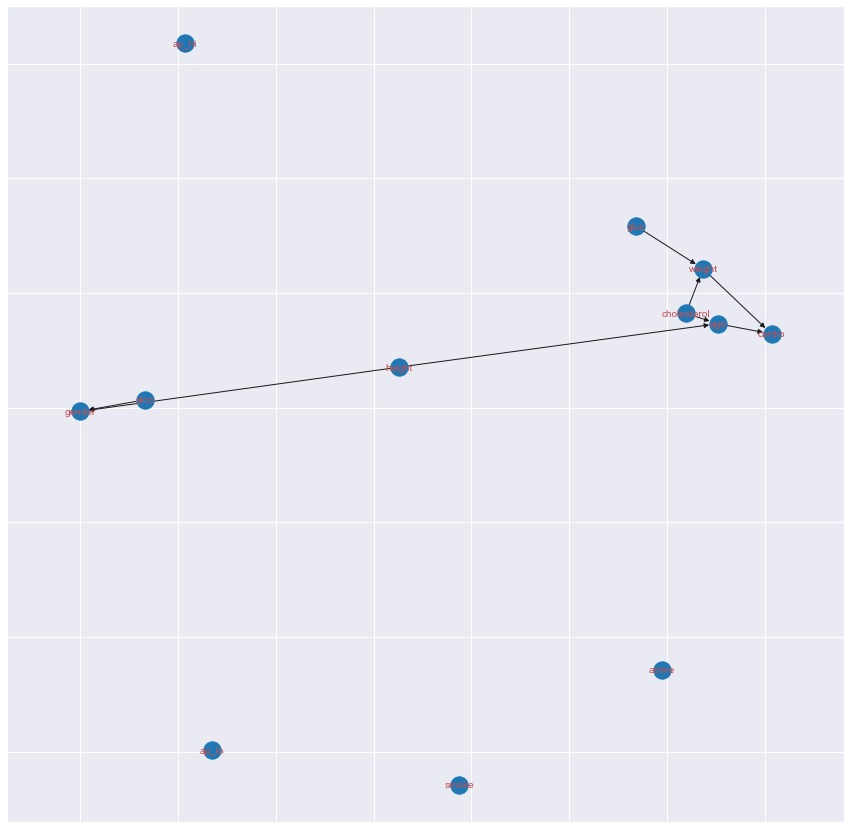

In [481]:
# GES algorithm
model_ges = cdt.causality.graph.GES()
graph_ges_c = model_ges.predict(cardio_df, skeleton_c)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_ges_c), font_size=10, font_color='r')
pd.DataFrame(list(graph_ges_c.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

## Unconstrained

##### Breast Cancer Data

,Cause,Effect,Score
0,diagnosis,area_worst,1
17,radius_worst,area_mean,1
31,concavity_worst,area_mean,1
30,concavity_worst,perimeter_mean,1
29,concavity_worst,concave points_mean,1
28,concavity_worst,concave points_worst,1
27,concavity_mean,area_mean,1
26,concavity_mean,radius_mean,1
25,concavity_mean,concave points_worst,1
24,area_mean,area_worst,1


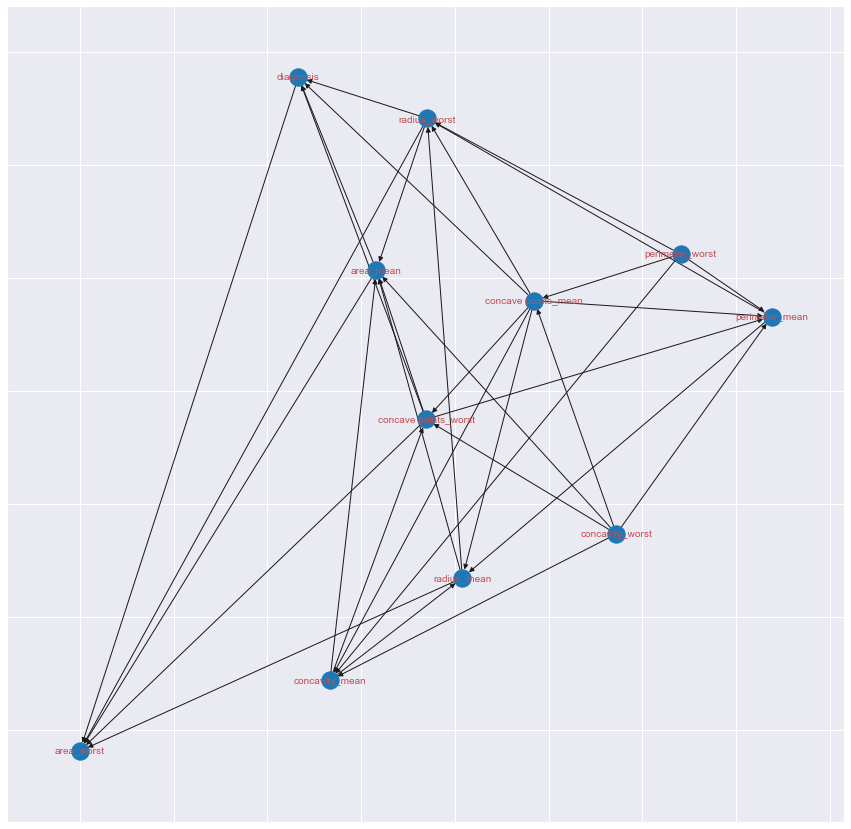

In [482]:
# GES algorithm
model_ges = cdt.causality.graph.GES()
graph_ges_u = model_ges.predict(breast_cancer_df)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_ges_u), font_size=10, font_color='r')
pd.DataFrame(list(graph_ges_u.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

##### Thyroid Data

,Cause,Effect,Score
0,binaryClass,sex,1
15,pregnant,query hyperthyroid,1
27,TSH measured,query hyperthyroid,1
26,TSH measured,query on thyroxine,1
25,TSH measured,on thyroxine,1
24,TSH measured,age,1
23,psych,TSH measured,1
22,psych,on thyroxine,1
21,psych,age,1
20,hypopituitary,query on thyroxine,1


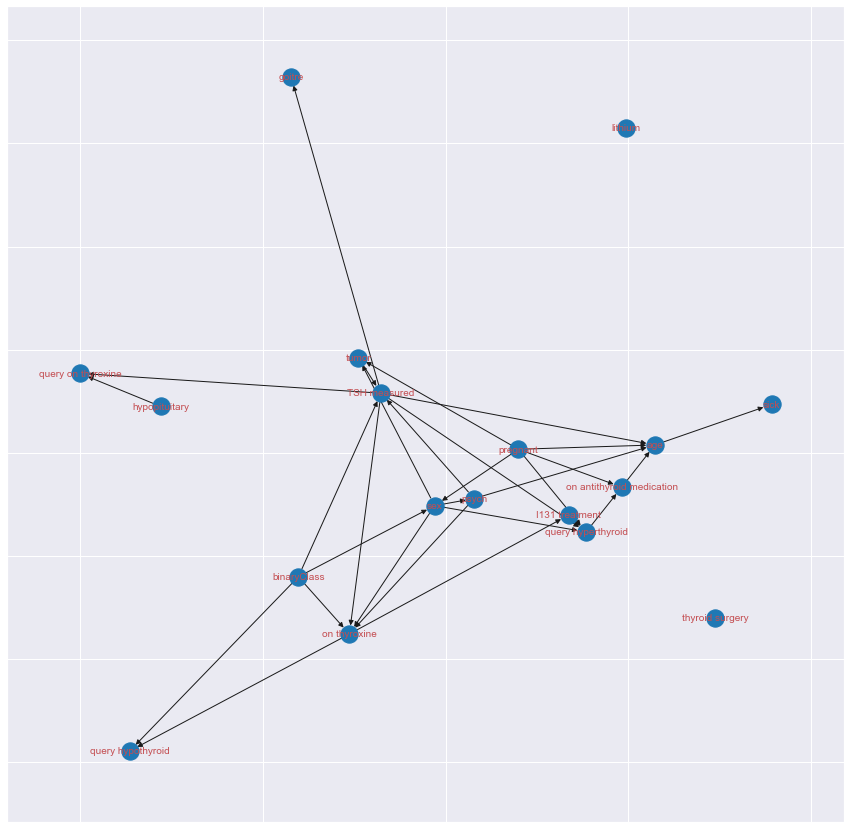

In [514]:
# GES algorithm
model_ges = cdt.causality.graph.GES()
graph_ges_u = model_ges.predict(thyroid_df)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_ges_u), font_size=10, font_color='r')
pd.DataFrame(list(graph_ges_u.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

##### Cardio Data

,Cause,Effect,Score
0,age,gender,1
1,age,height,1
20,gluc,weight,1
21,smoke,cholesterol,1
22,smoke,alco,1
23,alco,weight,1
24,alco,cholesterol,1
25,active,cholesterol,1
26,active,gluc,1
27,active,smoke,1


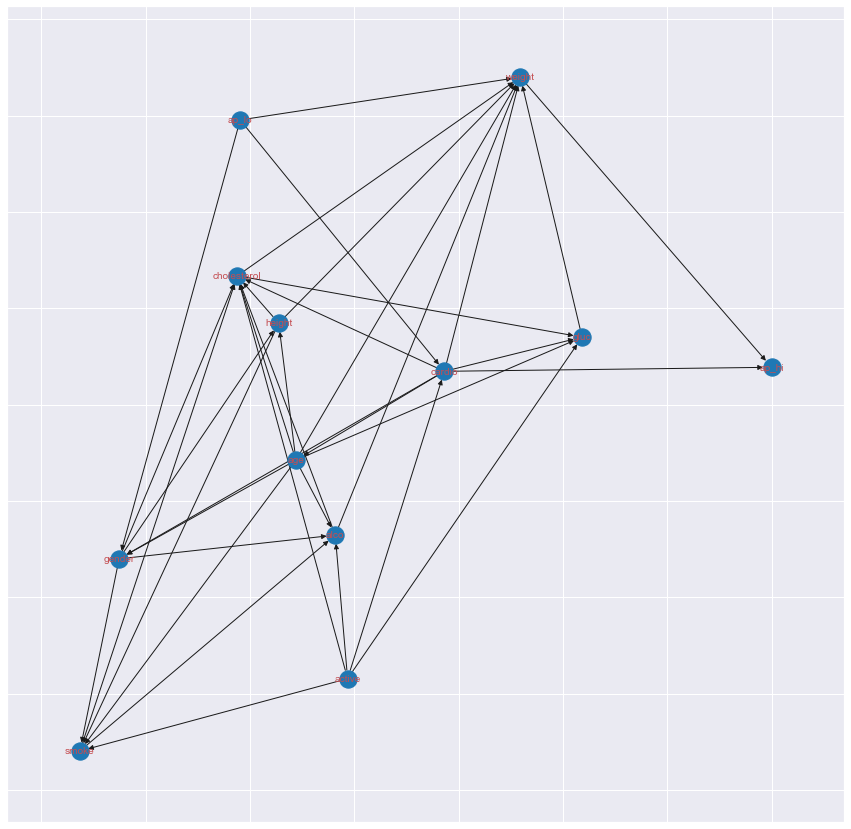

In [484]:
# GES algorithm
model_ges = cdt.causality.graph.GES()
graph_ges_u = model_ges.predict(cardio_df)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_ges_u), font_size=10, font_color='r')
pd.DataFrame(list(graph_ges_u.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

# LiNGAM

## Unconstrained (LiNGAM cannot be perfomed constrained)

##### Breast Cancer Data

,Cause,Effect,Score
5,concave points_worst,perimeter_mean,5.81
25,concavity_mean,perimeter_mean,5.37
13,concave points_mean,perimeter_mean,5.30
1,diagnosis,perimeter_mean,1.34
29,concavity_worst,concavity_mean,1.28
8,perimeter_worst,perimeter_mean,1.13
23,area_mean,perimeter_mean,1.10
19,area_worst,radius_worst,1.04
16,radius_worst,radius_mean,0.97
17,perimeter_mean,radius_mean,0.96


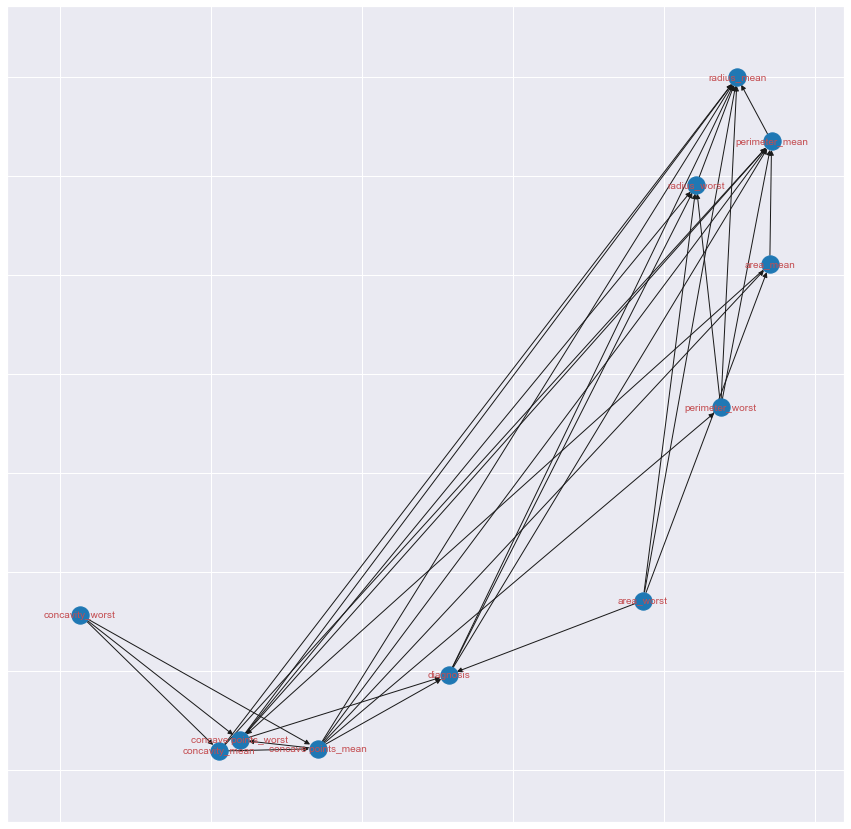

In [485]:
# LiNGAM Algorithm
model_lingam = cdt.causality.graph.LiNGAM()
graph_lingam = model_lingam.predict(breast_cancer_df)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_lingam), font_size=10, font_color='r')
pd.DataFrame(list(graph_lingam.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

##### Thyroid Data

,Cause,Effect,Score
11,on thyroxine,binaryClass,0.34
35,tumor,pregnant,0.14
39,psych,binaryClass,0.13
18,pregnant,binaryClass,0.12
6,age,TSH measured,0.11
26,goitre,binaryClass,0.10
13,on thyroxine,query hypothyroid,0.10
10,sex,psych,0.09
55,TSH measured,psych,0.07
1,age,sick,0.07


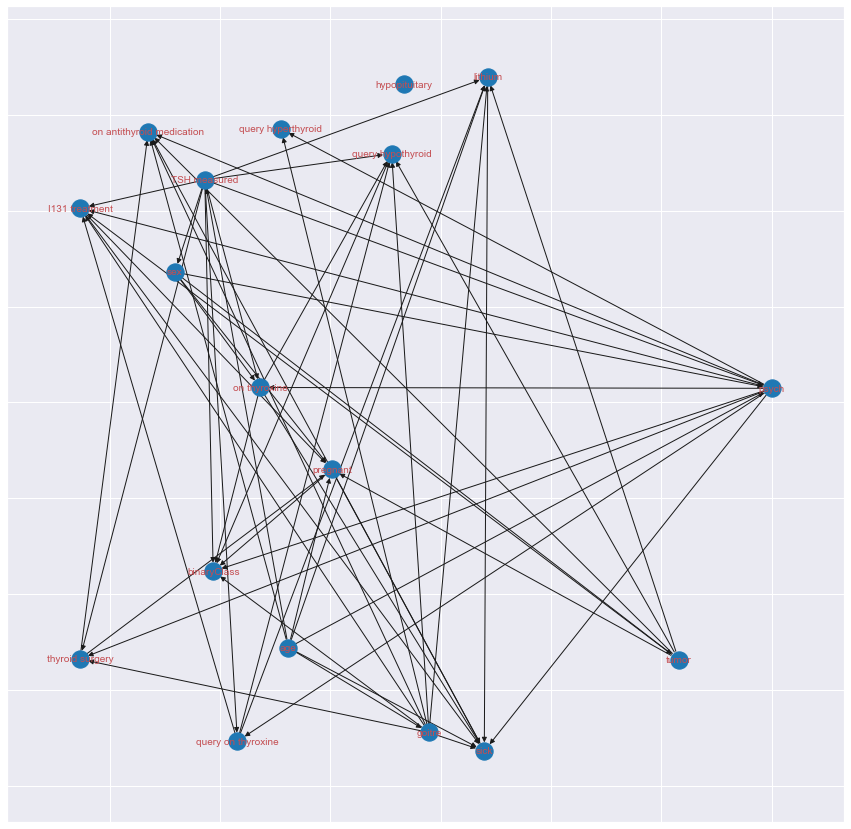

In [486]:
# LiNGAM Algorithm
model_lingam = cdt.causality.graph.LiNGAM()
graph_lingam = model_lingam.predict(thyroid_df)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_lingam), font_size=10, font_color='r')
pd.DataFrame(list(graph_lingam.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

##### Cardio Data

,Cause,Effect,Score
2,height,gender,0.50
13,cholesterol,gluc,0.43
19,smoke,gender,0.33
26,alco,smoke,0.32
4,weight,height,0.29
31,cardio,age,0.19
35,cardio,cholesterol,0.17
33,cardio,weight,0.14
17,gluc,weight,0.11
11,cholesterol,weight,0.10


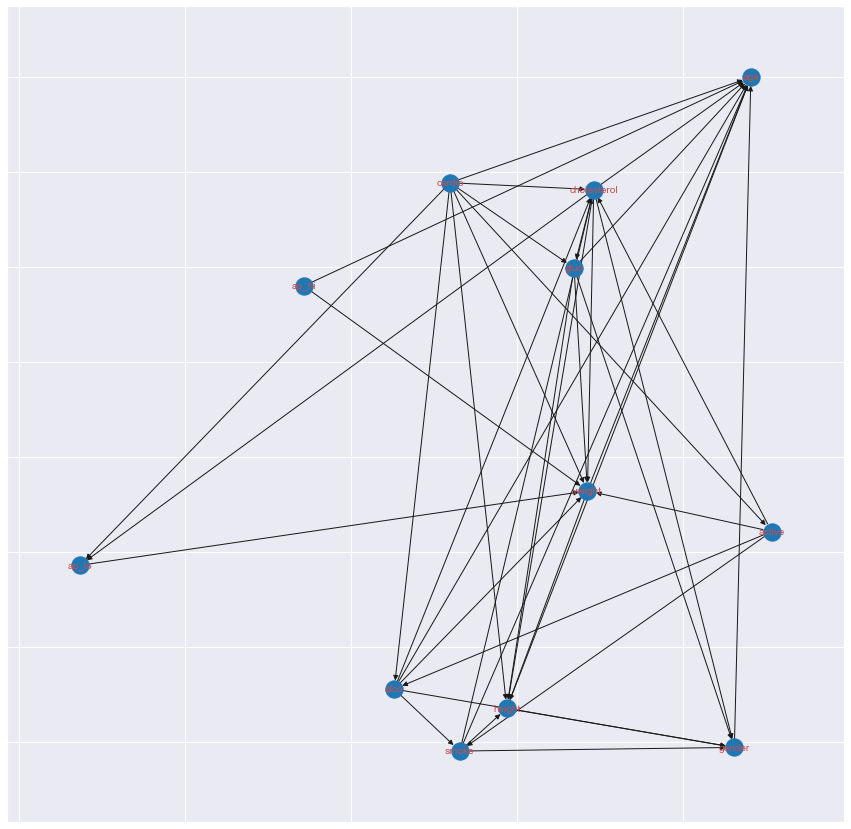

In [487]:
# LiNGAM Algorithm
model_lingam = cdt.causality.graph.LiNGAM()
graph_lingam = model_lingam.predict(cardio_df)

# visualize network
fig=plt.figure(figsize=(15,15))
nx.draw_networkx(dagify_min_edge(graph_lingam), font_size=10, font_color='r')
pd.DataFrame(list(graph_lingam.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

# Synthetic data

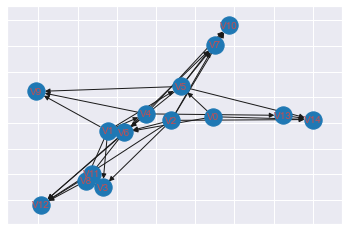

In [500]:
import random
random.seed(42)
np.random.seed(42)

generator = AcyclicGraphGenerator('linear', npoints=5000, nodes=15)
data, graph = generator.generate()
#generator.to_csv('generated_graph')

nx.draw_networkx(graph, font_size=10, font_color='r')

## Skeleton

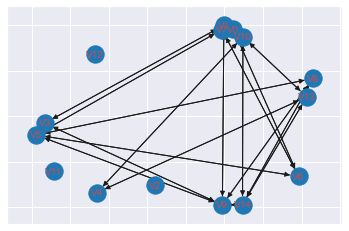

In [501]:
# intialize graph lasso
glasso = cdt.independence.graph.Glasso()

# apply graph lasso to dataset
skeleton = glasso.predict(data, 0.8)
skeleton.remove_edges_from(nx.selfloop_edges(skeleton))

# visualize network
fig=plt.figure()
nx.draw_networkx(skeleton, font_size=10, font_color='r')

In [502]:
nx.is_directed_acyclic_graph(skeleton) # => True

False

## PC

### Constrained

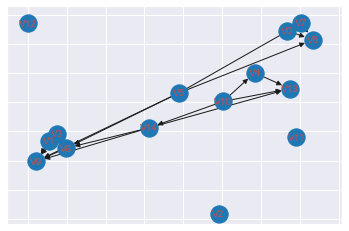

In [503]:
model_pc = cdt.causality.graph.PC()
predict = model_pc.predict(data, skeleton)

nx.draw_networkx(dagify_min_edge(predict), font_size=10, font_color='r')

PC (constrained):
Structural hamming distance: 36
Area under the curve: 0.359


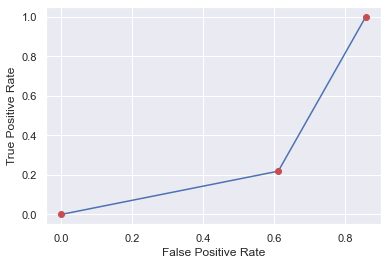

,Cause,Effect,Score
0,V0,V6,1
1,V0,V7,1
16,V7,V6,1
15,V5,V9,1
14,V5,V8,1
13,V5,V7,1
12,V5,V6,1
11,V4,V13,1
10,V3,V9,1
9,V14,V9,1


In [504]:
shd = cdt.metrics.SHD(graph, predict)
auc, roc = cdt.metrics.precision_recall(graph, predict)

# Correction for plotting 
roc = tuple([(1-t[0], t[1]) for t in roc])
fpr = [x[0] for x in roc]
tpr = [x[1] for x in roc]

print("PC (constrained):")
print(f"Structural hamming distance: {shd}")
print(f"Area under the curve: {auc:.3f}")

plt.plot(fpr,tpr)
plt.plot(fpr,tpr,'or')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

pd.DataFrame(list(predict.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

### Unconstrained

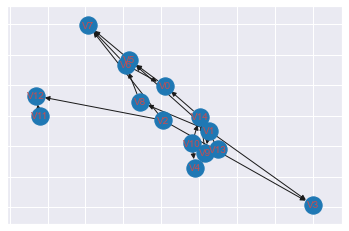

In [505]:
model_pc = cdt.causality.graph.PC()
predict = model_pc.predict(data)

nx.draw_networkx(dagify_min_edge(predict), font_size=10, font_color='r')


PC (unconstrained):
Structural hamming distance: 26
Area under the curve: 0.570


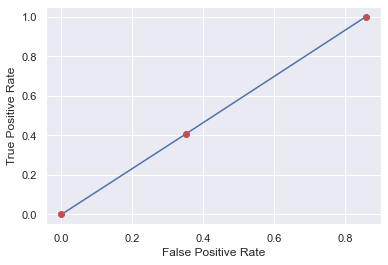

,Cause,Effect,Score
0,V0,V5,1
1,V1,V3,1
18,V13,V14,1
17,V11,V12,1
16,V10,V14,1
15,V10,V4,1
14,V9,V14,1
13,V8,V6,1
12,V6,V7,1
11,V6,V5,1


In [506]:
shd = cdt.metrics.SHD(graph, predict)
auc, roc = cdt.metrics.precision_recall(graph, predict)

# Correction for plotting 
roc = tuple([(1-t[0], t[1]) for t in roc])
fpr = [x[0] for x in roc]
tpr = [x[1] for x in roc]

print("PC (unconstrained):")
print(f"Structural hamming distance: {shd}")
print(f"Area under the curve: {auc:.3f}")

plt.plot(fpr,tpr)
plt.plot(fpr,tpr,'or')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
pd.DataFrame(list(predict.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

## GES

### Constrained

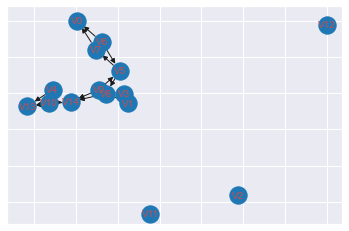

In [507]:
model_ges = cdt.causality.graph.GES()
predict = model_ges.predict(data, skeleton)

nx.draw_networkx(dagify_min_edge(predict), font_size=10, font_color='r')

GES (constrained):
Structural hamming distance: 40
Area under the curve: 0.277


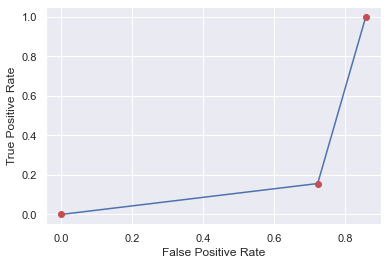

,Cause,Effect,Score
0,V1,V3,1
1,V1,V9,1
16,V9,V5,1
15,V9,V14,1
14,V8,V14,1
13,V7,V0,1
12,V6,V7,1
11,V6,V5,1
10,V6,V0,1
9,V5,V8,1


In [508]:
shd = cdt.metrics.SHD(graph, predict)
auc, roc = cdt.metrics.precision_recall(graph, predict)

# Correction for plotting 
roc = tuple([(1-t[0], t[1]) for t in roc])
fpr = [x[0] for x in roc]
tpr = [x[1] for x in roc]

print("GES (constrained):")
print(f"Structural hamming distance: {shd}")
print(f"Area under the curve: {auc:.3f}")

plt.plot(fpr,tpr)
plt.plot(fpr,tpr,'or')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
pd.DataFrame(list(predict.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

### Unconstrained

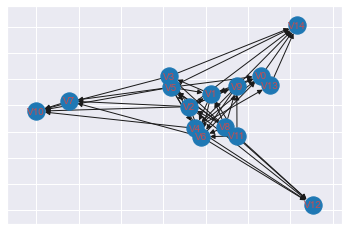

In [509]:
model_ges = cdt.causality.graph.GES()
predict = model_ges.predict(data)

nx.draw_networkx(dagify_min_edge(predict), font_size=10, font_color='r')

GES (unconstrained):
Structural hamming distance: 40
Area under the curve: 0.578


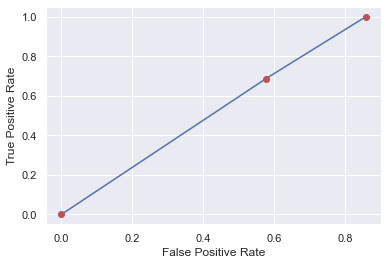

,Cause,Effect,Score
0,V0,V14,1
1,V1,V0,1
28,V5,V10,1
29,V5,V14,1
30,V6,V0,1
31,V6,V4,1
32,V6,V7,1
33,V6,V12,1
34,V7,V10,1
35,V8,V1,1


In [510]:
shd = cdt.metrics.SHD(graph, predict)
auc, roc = cdt.metrics.precision_recall(graph, predict)

# Correction for plotting 
roc = tuple([(1-t[0], t[1]) for t in roc])
fpr = [x[0] for x in roc]
tpr = [x[1] for x in roc]

print("GES (unconstrained):")
print(f"Structural hamming distance: {shd}")
print(f"Area under the curve: {auc:.3f}")

plt.plot(fpr,tpr)
plt.plot(fpr,tpr,'or')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
pd.DataFrame(list(predict.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

## LiNGAM

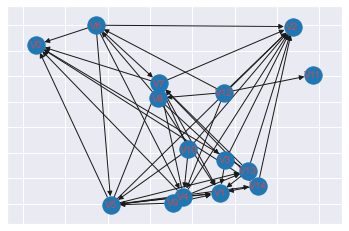

In [511]:
model_lingam = cdt.causality.graph.LiNGAM()
predict = model_lingam.predict(data)

nx.draw_networkx(dagify_min_edge(predict), font_size=10, font_color='r')

LiNGAM:
Structural hamming distance: 68
Area under the curve: 0.230


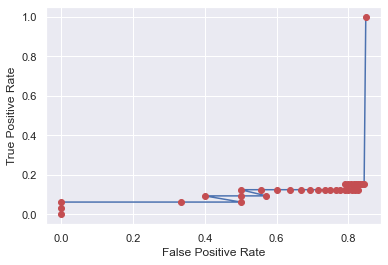

,Cause,Effect,Score
13,V5,V14,1.63
41,V13,V14,1.49
45,V14,V7,1.02
0,V3,V1,1.00
18,V6,V7,0.89
29,V10,V4,0.81
19,V7,V0,0.79
7,V4,V13,0.75
24,V8,V6,0.62
25,V9,V1,0.60


In [512]:
shd = cdt.metrics.SHD(graph, predict)
auc, roc = cdt.metrics.precision_recall(graph, predict)

# Correction for plotting 
roc = tuple([(1-t[0], t[1]) for t in roc])
fpr = [x[0] for x in roc]
tpr = [x[1] for x in roc]

print("LiNGAM:")
print(f"Structural hamming distance: {shd}")
print(f"Area under the curve: {auc:.3f}")

plt.plot(fpr,tpr)
plt.plot(fpr,tpr,'or')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
pd.DataFrame(list(predict.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")